In [12]:
import zipfile
from PIL import Image, ImageFont, ImageDraw
import pytesseract
import cv2 as cv
import numpy

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default1.xml')


In [13]:
archive = zipfile.ZipFile('small_img.zip', 'r')

def get_processed_image(image):
    """
    Proccesses a image, converting it to grayscale and using gaussian blur. Convertion between PIL and OpenCV is used
    :param image: pillow object
    :return:processed PIL image
    """
    #Convert to OpenCV
    open_cv_image = cv.cvtColor(numpy.array(image), cv.COLOR_RGB2BGR)
    gray = cv.cvtColor(open_cv_image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)
    #PIL image, converted from OpenCV is returned
    return Image.fromarray(cv.cvtColor(blurred, cv.COLOR_BGR2RGB))

def get_text(image):
    """
    Proccesses the image and extracts text in it using tessseract
    :param image: PIL image
    :return: string with the text, found in the image
    """
    processed_image = get_processed_image(image)
    return pytesseract.image_to_string(processed_image, lang='eng')

def get_bounding_boxes(image):
    """
    Proccesses the image using get_processed_image() function and detects all the faces. Convertion from PIL to OpenCV is used
    :param image: PIL image
    :return: a list of bounding boxes, returned by cv.DetectMultiscale()
    """
    processed_image = get_processed_image(image)
    #Convert to OpenCV
    processed_image = cv.cvtColor(numpy.array(processed_image), cv.COLOR_RGB2BGR)
    bounding_boxes = face_cascade.detectMultiScale(processed_image, scaleFactor= 1.15, minNeighbors= 7, minSize= (20,20))
    return bounding_boxes

def crop_face(image, bounding_box):
    """
    Crops a face from the image.
    :param image: source image, which contains faces
    :param bounding_box: a rectangle, which is represented by a list of width, height and x, y coordinates
            (The list of these bounding boxes is returned by get_bounding_boxes() function)
    :return: PIL image, which contains face only
    """
    x, y, w, h = tuple(bounding_box)
    return image.crop((x, y, x + w, y + h))

def create_blank_with_faces(image, bounding_boxes):
    """
    Creates an image with detected faces, sorted by its size
    :param image: PIL image. Source image, where faces where detected
    :param bounding_boxes: a list of bounding boxes for faces, returned by get_bounding_boxes() function
    :return: PIL image, which contains only detected faces

    FACE_WIDTH and FACE_HEIGHT are standart width and height of faces to paste into blank (200x200)
    Image.thumbnail() is used, which modifies the image to contain a thumbnail version of itself, no larger than the given size
    It means that all the faces which are smaller than (FACE_WIDTH, FACE_HEIGHT) save its size
    """
    x = 0
    y = 0
    #Sort list by the size of faces
    bounding_boxes = sorted(bounding_boxes, key= lambda bounding_box: bounding_box[2]*bounding_box[3], reverse= True)
    #Create a black blank for faces to paste
    blank = Image.new('RGB', (FACE_WIDTH*5, FACE_HEIGHT))
    for bounding_box in bounding_boxes:
        face = crop_face(image, bounding_box)
        #Resize face
        face.thumbnail((FACE_WIDTH, FACE_HEIGHT))
        if face.width > blank.width - x:
            #New row is required
            x = 0
            y += FACE_HEIGHT
            #Create a new row
            new_row = Image.new('RGB', (blank.width, FACE_HEIGHT))
            #Create empty image, which will contain upper rows and the new row
            #This image is used to join two images (upper rows of faces and new row)
            new_blank = Image.new('RGB', (blank.width, new_row.height + blank.height))
            #Paste older rows(blank) into this empty image
            new_blank.paste(blank, (0, 0))
            #Paste new row
            new_blank.paste(new_row,(x, y))
            #Update blank
            blank = new_blank
        #New row is not required
        blank.paste(face, (x, y))
        x += face.width

    return blank

In [14]:
SHEET_WIDTH = 1100
TEXT_HEIGHT = 80

FACE_WIDTH = 200
FACE_HEIGHT = 200

fnt = ImageFont.truetype("Roboto-Regular.ttf", 55)

#Initialize a contact_sheet image, which height iz zero
#It is required for the first iteration of the loop below
contact_sheet = Image.new('RGB', (SHEET_WIDTH, 0), (255, 255, 255))

request = 'Students'

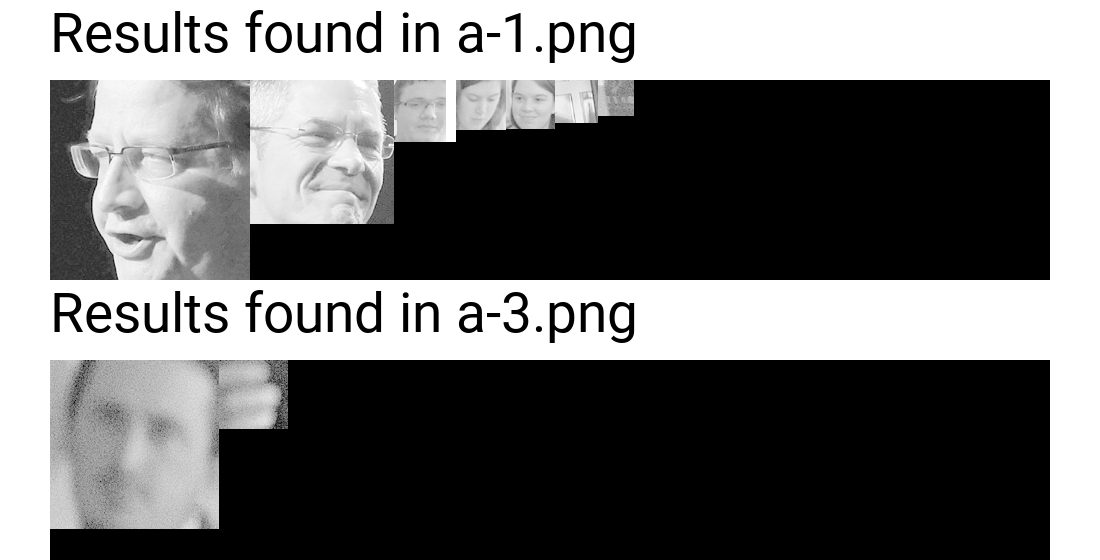

In [15]:
#We iterate through all images in the archive, open each of them as a file object and then as PIL image
#We extract text from the image and if required string is found in this text, we continue to create contact sheet
#First we create a blank with faces, returned by create_blank_with_faces() function
#Then we create the image for the whole section. This section with white background contains text and image with blank
#The width of the section is SHEET_WIDTH (1100), which means that there will be 50 pixels of whitespace to left and to the right of the blank
#When the section is fully completed we need to add it to our contact sheet
#We do it by joining 2 images: new_section and contact_sheet
#As in create_blank_with_faces() function we need to create an empty image(new_contact_sheet)
#Then we paste older contact sheet(empty image in the first iteration) and new section to our contact sheet
for name in archive.namelist():
    with archive.open(name, 'r') as img_file:
        image = Image.open(img_file)
        if request in get_text(image):
            bounding_boxes = get_bounding_boxes(image)
            blank_with_faces = create_blank_with_faces(image, bounding_boxes)
            new_section = Image.new('RGB', (SHEET_WIDTH, TEXT_HEIGHT + blank_with_faces.height), (255, 255, 255))
            new_section.paste(blank_with_faces, (50, TEXT_HEIGHT))

            drawer = ImageDraw.Draw(new_section)
            if len(bounding_boxes[0]) == 0:
                drawer.text((50, 0), 'There are no faces in {}'.format(name), font = fnt, fill = (0, 0, 0))
            else:
                drawer.text((50, 0), 'Results found in {}'.format(name), font = fnt, fill = (0, 0, 0))
            new_contact_sheet = Image.new('RGB', (SHEET_WIDTH, contact_sheet.height + new_section.height), (255, 255, 255))
            new_contact_sheet.paste(contact_sheet,(0, 0))
            new_contact_sheet.paste(new_section, (0, contact_sheet.height))
            #Update contact sheet
            contact_sheet = new_contact_sheet

display(contact_sheet)